# Train a Class-Conditioned Diffusion Mode with 🤗 Diffusers

## 이 파일에서 학습할 내용

- PoC(Proof of Concept)를 위한 간단한 조건부 이미지 생성 모델을  MNIST를 사용하여 밑바닥부터 학습




## Step 1: Setup

- 다음 셀을 실행하여 디퓨저 라이브러리와 몇 가지 다른 요구 사항을 설치

In [1]:
# !pip install -qU diffusers

In [2]:
import diffusers

diffusers.__version__

'0.31.0'

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

- 디바이스 세팅

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


## Step 2: Prepare a training dataset

- pytorch로 부터 MNIST데이터 셋 다운로드

- 이미지 배치를 그리드 형태로 바꿔 표시할 보조 함수 정의

In [5]:
def show_images(x, return_type='PIL'):
    """Given a batch of images x, make a grid and convert to PIL"""

    # Map from (-1, 1) back to (0, 1)
    x = x * 0.5 + 0.5

    # (B x C x H x W) -> (C x H x W)인 이미지를 (B/nrow, nrow)인 격자형태로.
    # Default nrow: 8
    # 1채널 이미지가 입력되도 반환은 3채널로 됨
    grid = torchvision.utils.make_grid(x)

    #                             ch last,         (0,1) -> (0,255)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255

    if return_type == 'PIL':
        # PIL 이미지로 리턴하는 경우
        # tensor -> ndarray -> Image
        grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    else:
        # numpy 어레이로 리턴하는 경우
        # tensor -> ndarray
        # ndarray(H,W,C)
        grid_im = np.array(grid_im).astype(np.uint8)

    return grid_im

In [6]:
from torchvision import transforms

image_size = 28
batch_size = 128

# Define data augmentations
preprocess = transforms.Compose(
    [
        # transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)

In [7]:
dataset = torchvision.datasets.FashionMNIST(
    root="mnist/", train=True, download=True,
    transform=preprocess)

100%|██████████| 26.4M/26.4M [00:00<00:00, 115MB/s]


Extracting mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to mnist/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 9.40MB/s]


Extracting mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to mnist/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 63.5MB/s]


Extracting mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to mnist/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.90MB/s]


Extracting mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/FashionMNIST/raw



In [8]:
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

Input shape: torch.Size([128, 1, 28, 28])
Labels: tensor([6, 9, 5, 6, 1, 3, 2, 0, 8, 0, 2, 7, 4, 1, 8, 2, 1, 0, 0, 9, 3, 0, 7, 5,
        9, 5, 8, 4, 0, 3, 9, 2, 6, 4, 3, 8, 8, 3, 5, 9, 1, 5, 4, 2, 9, 0, 1, 6,
        8, 4, 8, 4, 2, 4, 2, 4, 1, 8, 2, 1, 3, 9, 8, 7, 6, 2, 5, 8, 2, 9, 9, 7,
        4, 4, 7, 1, 4, 5, 3, 4, 0, 0, 6, 9, 2, 9, 7, 4, 3, 2, 3, 1, 6, 7, 7, 9,
        5, 8, 0, 7, 5, 4, 9, 4, 9, 7, 2, 9, 4, 3, 4, 9, 7, 9, 8, 9, 8, 7, 9, 4,
        0, 1, 7, 9, 3, 4, 0, 8])
<class 'PIL.Image.Image'>


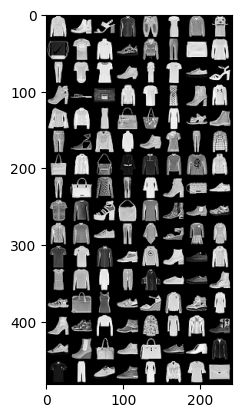

In [9]:
X, y = next(iter(train_dataloader))

print('Input shape:', X.shape)
print('Labels:', y)

grid_imgs = show_images(X)
print(type(grid_imgs))

plt.imshow(grid_imgs)

plt.show()

## Step 3: Define the Scheduler

- Diffusion 모델의 학습은 입력 이미지에 노이즈를 추가한 다음 노이즈 이미지를 모델에 공급하고 이미지에 추가된 노이즈를 예측하는 과정

- 따라서 어떤 스케쥴로 노이즈를 추가하는지도 모델의 학습에 영향을 미침

- DDPM([Denoising Diffusion Probabalistic Models](https://arxiv.org/abs/2006.11239))에서 기본적으로 사용하는 노이즈 스케쥴러를 세팅

In [11]:
from diffusers import DDPMScheduler

# `linear`(default), `scaled_linear`, or `squaredcos_cap_v2`.
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

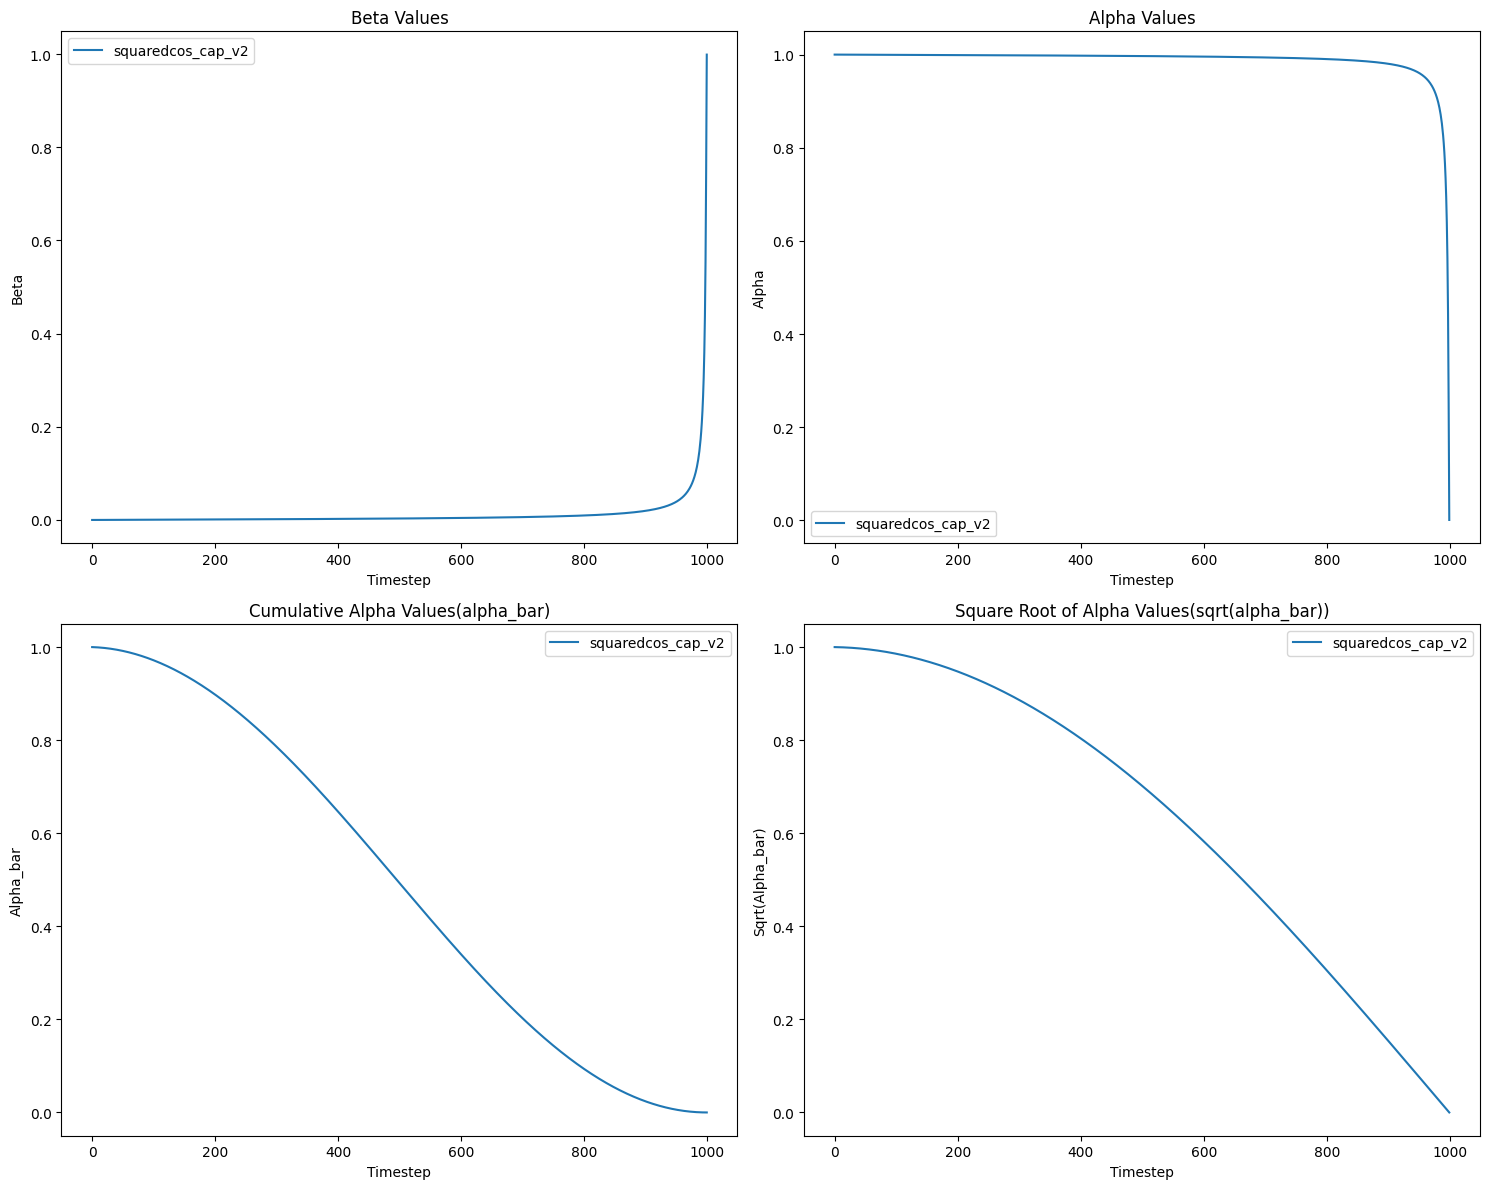

In [12]:
def plot_scheduler_params(beta_schedules):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    time_steps = np.arange(1000)

    for schedule in beta_schedules:
        # 스케줄러 초기화
        scheduler = DDPMScheduler(
            num_train_timesteps=1000,
            beta_schedule=schedule
        )

        # 베타값 추출
        betas = scheduler.betas.numpy()
        # 알파값 계산
        alphas = 1 - betas
        # 누적 알파값 계산
        alphas_bar = scheduler.alphas_cumprod.numpy()
        # sqrt(알파)값 계산
        sqrt_alphas_bar = np.sqrt(alphas_bar)

        # 베타값 그래프
        axes[0,0].plot(time_steps, betas, label=schedule)
        axes[0,0].set_title('Beta Values')
        axes[0,0].set_xlabel('Timestep')
        axes[0,0].set_ylabel('Beta')
        axes[0,0].legend()

        # 알파값 그래프
        axes[0,1].plot(time_steps, alphas, label=schedule)
        axes[0,1].set_title('Alpha Values')
        axes[0,1].set_xlabel('Timestep')
        axes[0,1].set_ylabel('Alpha')
        axes[0,1].legend()

        # 누적 알파값 그래프
        axes[1,0].plot(time_steps, alphas_bar, label=schedule)
        axes[1,0].set_title('Cumulative Alpha Values(alpha_bar)')
        axes[1,0].set_xlabel('Timestep')
        axes[1,0].set_ylabel('Alpha_bar')
        axes[1,0].legend()

        # sqrt(누적 알파) 그래프
        axes[1,1].plot(time_steps, sqrt_alphas_bar, label=schedule)
        axes[1,1].set_title('Square Root of Alpha Values(sqrt(alpha_bar))')
        axes[1,1].set_xlabel('Timestep')
        axes[1,1].set_ylabel('Sqrt(Alpha_bar)')
        axes[1,1].legend()

    plt.tight_layout()
    plt.show()

# 다양한 베타 스케줄 비교
beta_schedules = [
    # 'linear',
    # 'scaled_linear',
    'squaredcos_cap_v2',
]

plot_scheduler_params(beta_schedules)

X shape: torch.Size([8, 1, 28, 28])


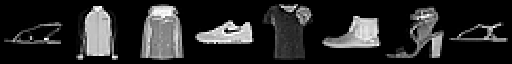

In [13]:
xb = next(iter(train_dataloader))[0].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

timesteps:  tensor([862, 599, 406, 453, 892, 555, 382, 862], device='cuda:0')
Noisy X shape torch.Size([8, 1, 28, 28])


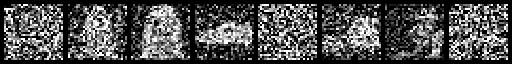

In [14]:
timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps, (8,)
        ).long().to(device)
print('timesteps: ', timesteps)

noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)

show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

## Step 4: Creating a Class-Conditioned UNet

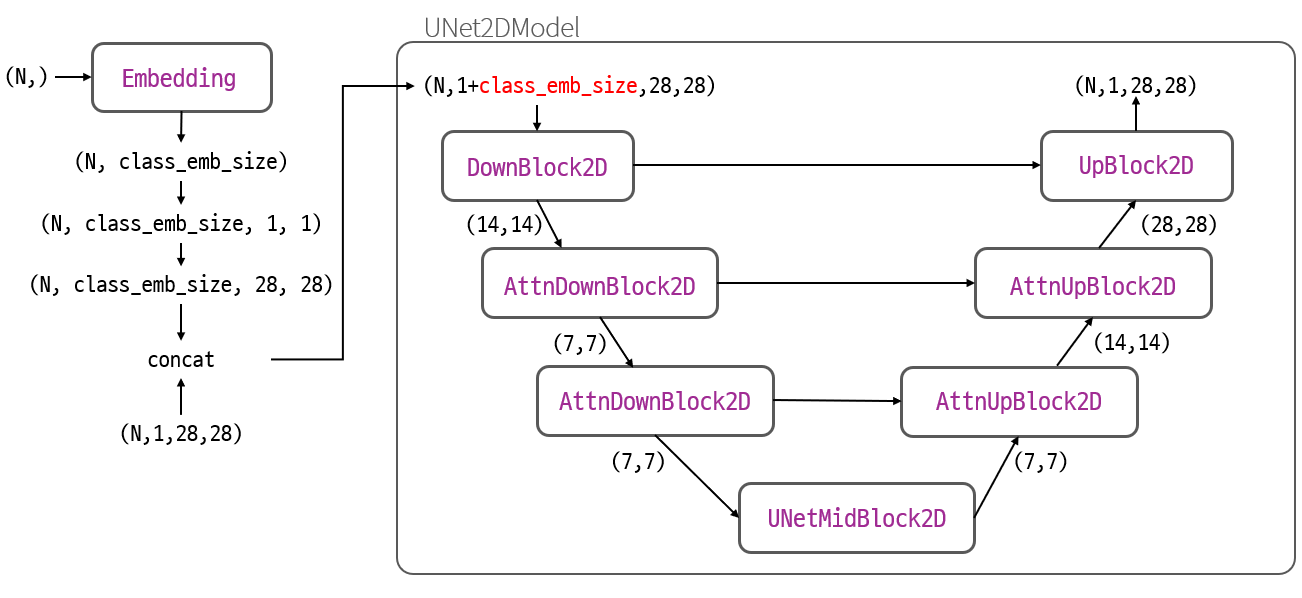

- 조건은 MNIST 숫자의 클래스가 되며 이 클래스 숫자를 임베딩하여 노이즈가 추가된 이미지와 같은 차원의 텐서로 만든 후 이미지 텐서와 직접 `concat`

- 이 방법은 확산 모델에 조건 정보를 추가할 수 있는 여러 가지 방법 중 하나이며  상대적으로 간단하고 이해하기 쉬움

- 다음 단계로 진행
    - 몇 가지 추가 입력 채널이 있는 표준 `UNet2DModel`을 생성

    - Map the class label to a learned vector of shape `(class_emb_size)` via an embedding layer

    - 임베딩 레이어를 통해 클래스 레이블을 벡터 `(class_emb_size,)`에 매핑

    - 이 정보를 내부 unet 입력에 대한 추가 채널로 `net_input = torch.cat((x, class_cond), 1)`을 사용하여 연결

    - `net_input`(총 (`class_emb_size+1`) 채널이 있는)을 unet에 공급하여 예측 생성

    - 이 코드에서 `class_emb_size`를 4로 설정했지만 이는 완전히 임의적인 값이며, 1(여전히 작동하는지 확인하기 위해), 10(클래스 수에 맞추기 위해), 또는 학습된 nn.Embedding을 클래스 라벨의 간단한 원핫 인코딩으로 직접 대체하는 방법등을 시도 가능

In [15]:
from diffusers import UNet2DModel

class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=image_size,           # the target image resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape

    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dinemsion
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the unet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Step 5: Create a Training Loop

> 이전 무조건부 생성에는 `noise_pred = model(noisy_images, timesteps).sample`와 같은 작업을 수행했다면, 이번에는 다음처럼 훈련 중에 세 번째 인수를 지정 `pred = net(noisy_x, timesteps, y)`

- 여기서 `y`는 0에서 9까지의 값을 가진 MNIST 숫자의 레이블


In [16]:
# 1h 30min / epoch on cpu, 2min / epoch on T4
n_epochs = 10

# Our network
net = ClassConditionedUnet().to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for X, y in tqdm(train_dataloader):
        optimizer.zero_grad()

        # Get some data and prepare the corrupted version
        X = X.to(device)
        y = y.to(device)
        noise = torch.randn_like(X)

        timesteps = torch.randint(0, 999, (X.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(X, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, y) # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        loss.backward()
        optimizer.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.088221


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 1. Average of the last 100 loss values: 0.079865


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 2. Average of the last 100 loss values: 0.075453


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 3. Average of the last 100 loss values: 0.073955


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 4. Average of the last 100 loss values: 0.071847


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 5. Average of the last 100 loss values: 0.070296


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 6. Average of the last 100 loss values: 0.068961


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 7. Average of the last 100 loss values: 0.069769


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 8. Average of the last 100 loss values: 0.068317


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 9. Average of the last 100 loss values: 0.068430


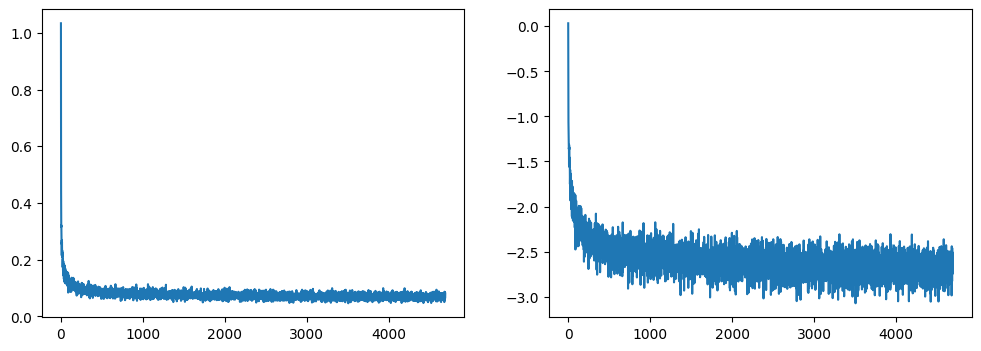

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
        6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
        9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0')


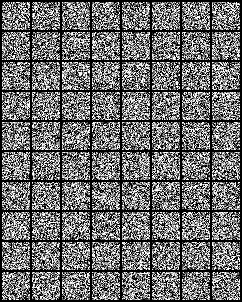

In [18]:
# Prepare random x to start from, plus some desired labels y
X = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

print(y)
show_images(X)

  0%|          | 0/1000 [00:00<?, ?it/s]

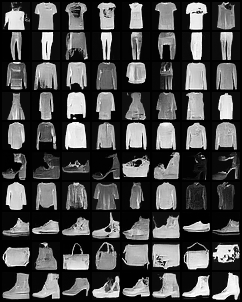

In [19]:
# Sampling loop
for i, t in enumerate(tqdm(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = net(X, t, y)

    # Update sample with step
    X = noise_scheduler.step(residual, t, X).prev_sample

# Show the results
show_images(X)

In [21]:
# 이 파일에서는 실습으로 fashion mnist 학습시켜 보기 (1시간 용)


torch.Size([80, 1, 28, 28])